### Initial Exploratory Data Analysis

This notebook uses the Music Dataset: 1950 to 2019 from Kaggle (https://www.kaggle.com/datasets/saurabhshahane/music-dataset-1950-to-2019/data) to perform some intial exploratory data analysis. 

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#### Load Dataset

In [2]:
# Update relative path as needed
df = pd.read_csv('music.csv')


#### Initial Inspection

In [3]:
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


# Initial inspection
print(f"Dataset dimensions: {df.shape}")
print("\nColumn overview:")
print(df.dtypes)
print("\nMissing values:")
print(df.isna().sum())

Dataset dimensions: (28372, 31)

Column overview:
Unnamed: 0                    int64
artist_name                  object
track_name                   object
release_date                  int64
genre                        object
lyrics                       object
len                           int64
dating                      float64
violence                    float64
world/life                  float64
night/time                  float64
shake the audience          float64
family/gospel               float64
romantic                    float64
communication               float64
obscene                     float64
music                       float64
movement/places             float64
light/visual perceptions    float64
family/spiritual            float64
like/girls                  float64
sadness                     float64
feelings                    float64
danceability                float64
loudness                    float64
acousticness                float64
instrumentalne

#### Basic statistics

In [4]:
numerical_features = ['danceability', 'energy', 'loudness', 
                     'acousticness', 'valence', 'age']
print("\nDescriptive statistics:")
display(df[numerical_features].describe())


Descriptive statistics:


,danceability,energy,loudness,acousticness,valence,age
count,28372.000000,28372.000000,28372.000000,2.837200e+04,28372.000000,28372.000000
mean,0.533348,0.569875,0.665249,3.392347e-01,0.532864,0.425187
std,0.173218,0.244385,0.108434,3.267143e-01,0.250972,0.264107
min,0.005415,0.000000,0.000000,2.811248e-07,0.000000,0.014286
25%,0.412975,0.380361,0.595364,3.423598e-02,0.329143,0.185714
50%,0.538612,0.580567,0.679050,2.259028e-01,0.539365,0.414286
75%,0.656666,0.772766,0.749026,6.325298e-01,0.738252,0.642857
max,0.993502,1.000000,1.000000,1.000000e+00,1.000000,1.000000


#### Feature Distributions

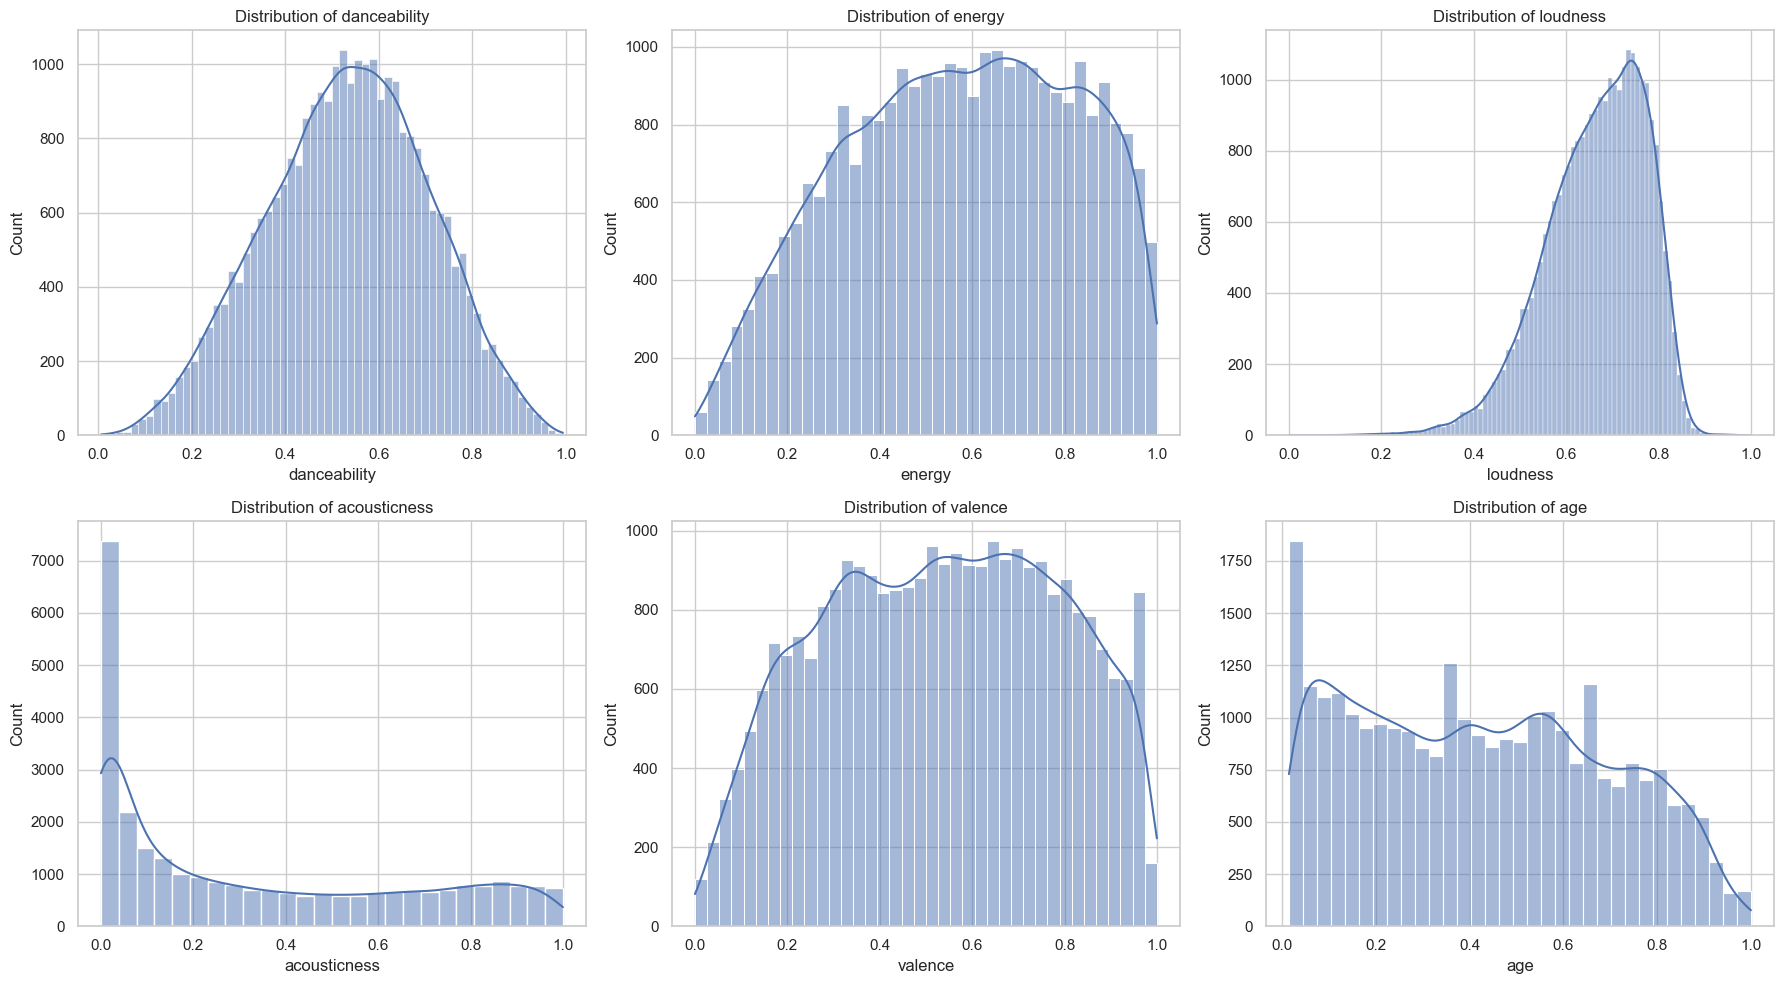

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], ax=axes[i//3, i%3], kde=True)
    axes[i//3, i%3].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

#### Correlation Analysis

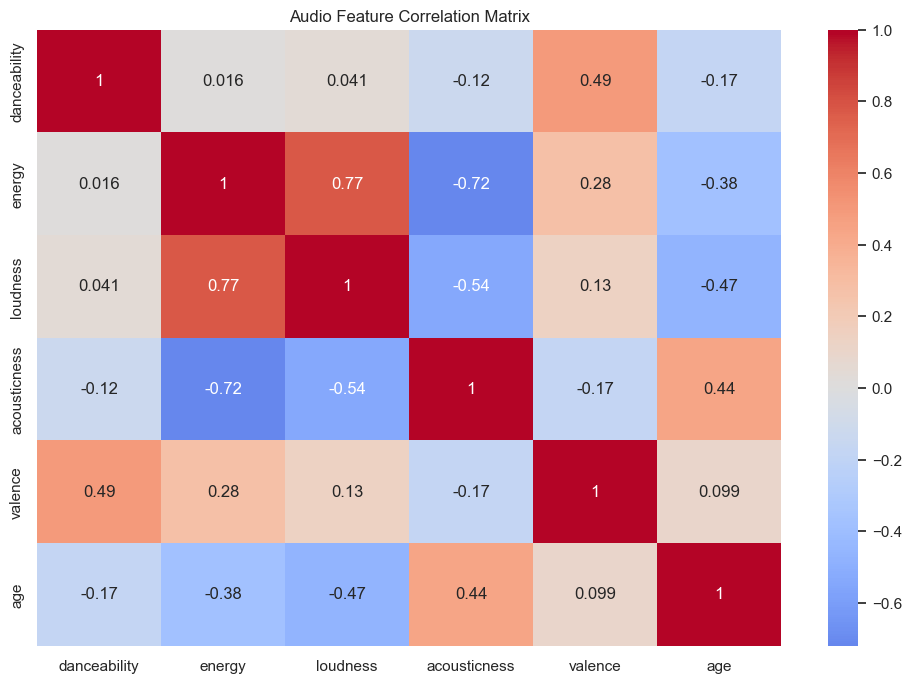

In [6]:
corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Audio Feature Correlation Matrix")
plt.show()

From this graph, we can see that loudness and energy has the highest positive correlation. Additionally, energy and acousticness has a strong inverse relationship. This makes sense as songs that are high in acousticness are typically low in energy. 

#### Clustering

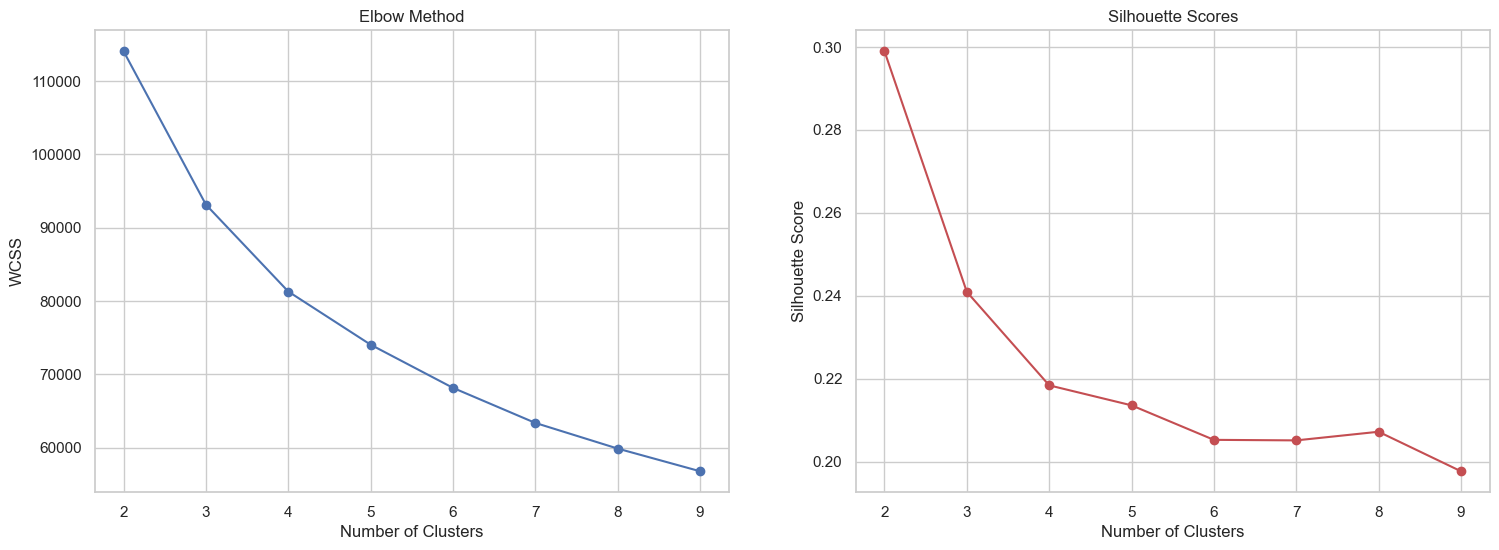

In [7]:
# Data preprocessing
X = df[numerical_features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %%
# Determine optimal clusters
wcss = []
silhouette_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(cluster_range, wcss, 'bo-')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS')

ax2.plot(cluster_range, silhouette_scores, 'ro-')
ax2.set_title('Silhouette Scores')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
plt.show()


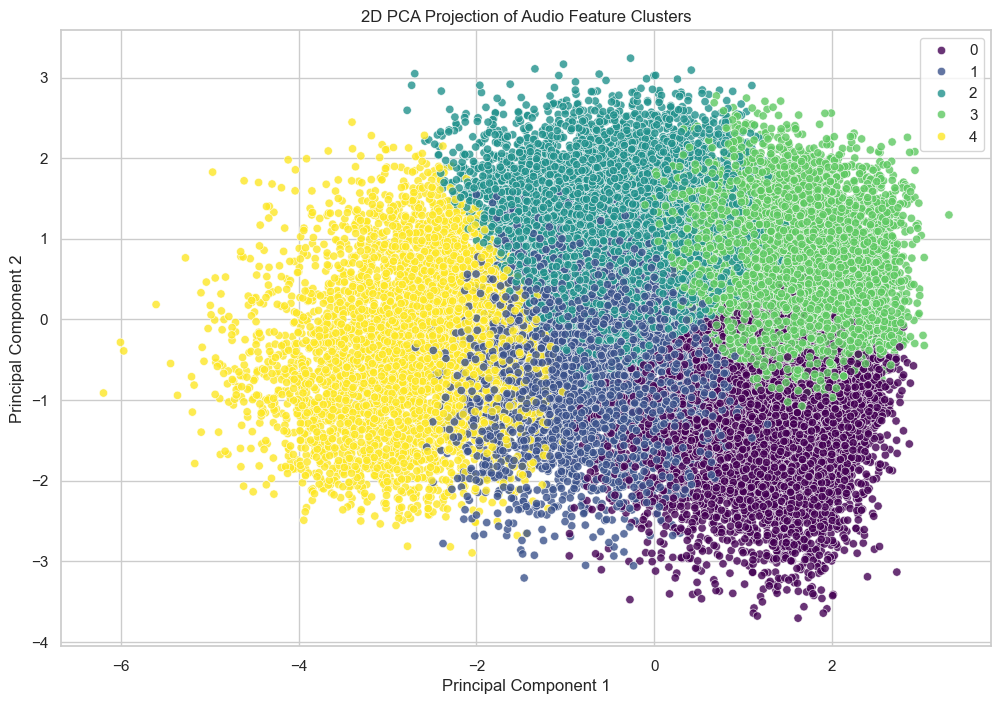

In [8]:
# Optimal cluster selection
optimal_clusters = 5  # Adjust based on elbow/silhouette analysis

# Final K-means model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df['cluster'] = np.nan
df.loc[X.index, 'cluster'] = clusters

# %%
# PCA visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1],
                hue=clusters, palette='viridis', alpha=0.8)
plt.title('2D PCA Projection of Audio Feature Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

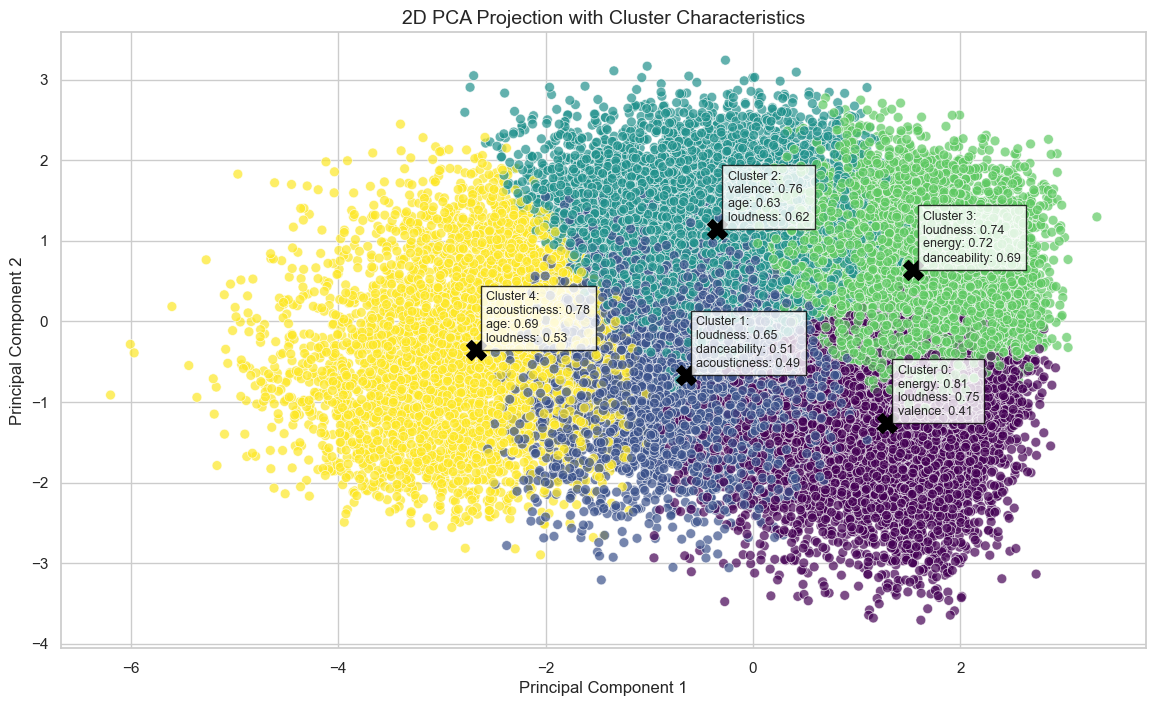


Cluster Feature Averages:


,danceability,energy,loudness,acousticness,valence,age
0,0.383317,0.814231,0.750113,0.065338,0.408944,0.316106
1,0.514578,0.406813,0.645357,0.493281,0.316770,0.270538
2,0.611178,0.543435,0.624917,0.368166,0.759720,0.628555
3,0.686403,0.717802,0.742100,0.140951,0.680335,0.207925
4,0.423426,0.233845,0.528977,0.782871,0.346256,0.689485


In [11]:
# Modified PCA visualization with cluster annotations

# Get cluster centers in original feature space
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=numerical_features)

# Get PCA coordinates for centroids
centroid_pca = pca.transform(kmeans.cluster_centers_)

# Create cluster descriptions
cluster_descriptions = []
for i in range(optimal_clusters):
    # Get top 3 features for each cluster
    top_features = centroid_df.iloc[i].sort_values(ascending=False).head(3)
    desc = f"Cluster {i}:\n" + "\n".join([
        f"{feat}: {val:.2f}" 
        for feat, val in zip(top_features.index, top_features.values)
    ])
    cluster_descriptions.append(desc)

# Plot with annotations
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    x=principal_components[:,0], 
    y=principal_components[:,1],
    hue=clusters, 
    palette='viridis', 
    alpha=0.7,
    s=50
)

# Add centroids and annotations
for i, (x, y) in enumerate(centroid_pca):
    plt.scatter(x, y, marker='X', s=200, c='black')
    plt.text(
        x + 0.1, y + 0.1, 
        cluster_descriptions[i], 
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

plt.title('2D PCA Projection with Cluster Characteristics', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend().remove()
plt.show()

# Show full cluster profiles
print("\nCluster Feature Averages:")
display(centroid_df.style.background_gradient(cmap='Blues', axis=0))


In [9]:
# Get feature loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns  # Your feature names
)

print("Feature Contributions:")
print(loadings)


Feature Contributions:
                   PC1       PC2
danceability  0.143105  0.673808
energy        0.540647 -0.083186
loudness      0.507944 -0.157271
acousticness -0.498999  0.061910
valence       0.192193  0.688037
age          -0.378518  0.192617


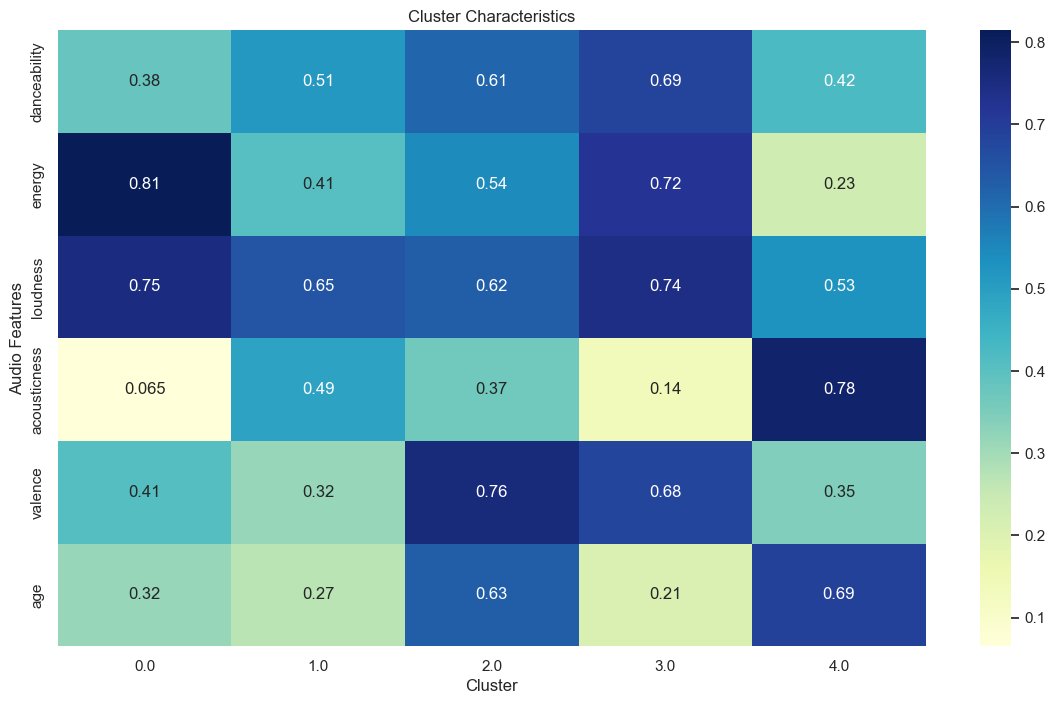

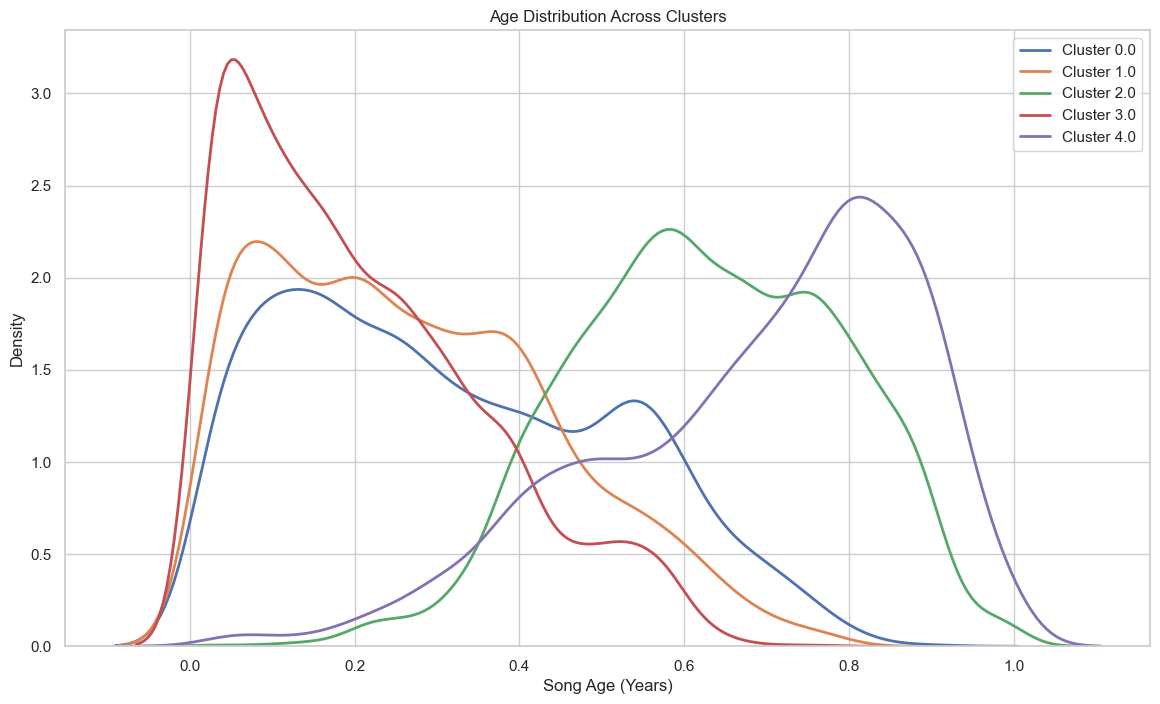

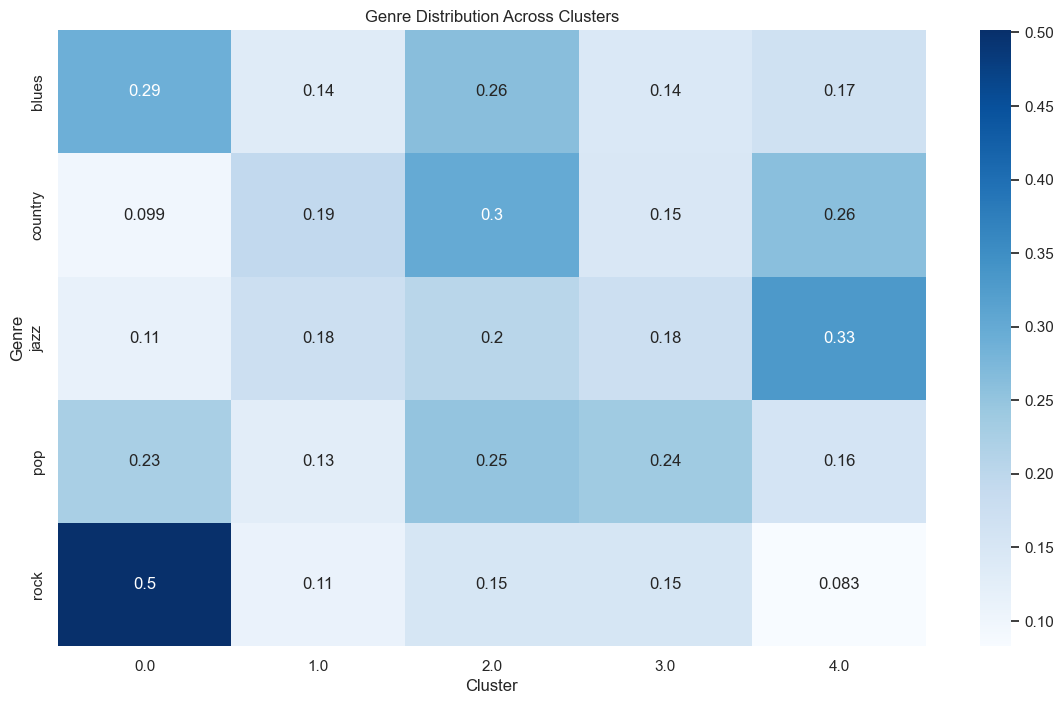

In [10]:


# Cluster analysis
cluster_profile = df.groupby('cluster')[numerical_features].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profile.T, annot=True, cmap='YlGnBu')
plt.title('Cluster Characteristics')
plt.ylabel('Audio Features')
plt.xlabel('Cluster')
plt.show()


# Temporal analysis
plt.figure(figsize=(14, 8))
for cluster in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster]
    sns.kdeplot(cluster_data['age'], label=f'Cluster {cluster}', linewidth=2)
plt.title('Age Distribution Across Clusters')
plt.xlabel('Song Age (Years)')
plt.ylabel('Density')
plt.legend()
plt.show()


# Genre distribution across clusters
top_genres = df['genre'].value_counts().head(5).index
genre_cluster = pd.crosstab(df[df['genre'].isin(top_genres)]['genre'], 
                           df['cluster'], normalize='index')

plt.figure(figsize=(14, 8))
sns.heatmap(genre_cluster, annot=True, cmap='Blues')
plt.title('Genre Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.show()

